In [1]:
import os

#os.chdir('/Users/user/Documents/GitHub/II2202_Stacking-Regression-Comparative-Study/src')
os.chdir('/Users/hamiddimyati/Documents/codes/stacking-regression-comparative-study/src')

In [31]:
import numpy as np
np.warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('ggplot')
import seaborn as sns
import re
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import time
import pickle

from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold, train_test_split, cross_validate
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet, BayesianRidge, HuberRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from pyearth import Earth
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from skoptimize import LinearSearch, DifferentialEvolution, GeneticAlgorithm, ParticleSwarmOptimization, SimulatedAnnealing, GreedySearch

In [5]:
#path = "/Users/user/Documents/GitHub/II2202_Stacking-Regression-Comparative-Study"
path = "/Users/hamiddimyati/Documents/codes/stacking-regression-comparative-study"

In [102]:
base_models = {'LinearRegression': LinearRegression(),
              'Ridge': Ridge(),
              'Lasso': Lasso(),
              'KernelRidge': KernelRidge(kernel='rbf'),
              'KNeighborsRegressor': KNeighborsRegressor(),
              'MLPRegressor': MLPRegressor(max_iter=1000),
              'SVR': SVR(),
              'DecisionTreeRegressor': DecisionTreeRegressor(),
              'Earth': Earth(),
              'BaggingRegressor': BaggingRegressor(),
              'RandomForestRegressor': RandomForestRegressor(),
              'GradientBoostingRegressor': GradientBoostingRegressor(),
              'XGBRegressor': XGBRegressor(),
              'LGBMRegressor': LGBMRegressor(),
              'CatBoostRegressor': CatBoostRegressor(verbose=False)}

meta_models = {'LinearRegression': LinearRegression(),
               'Ridge': Ridge(),
               'LinearSearch': LinearSearch(non_negative=True, sum_to_one=False), 
               'DifferentialEvolution': DifferentialEvolution(size_pop=1000, max_iter=1000, non_negative=False, sum_to_one=False), 
               'GeneticAlgorithm': GeneticAlgorithm(size_pop=1000, max_iter=1000, non_negative=False, sum_to_one=False), 
               'ParticleSwarmOptimization': ParticleSwarmOptimization(pop=1000, max_iter=1000, w=0.8, c1=0.5, c2=0.5, non_negative=False, sum_to_one=False), 
               'SimulatedAnnealing': SimulatedAnnealing(T_max=1, T_min=1e-9, L=500, max_stay_counter=1000), 
               'GreedySearch': GreedySearch(convergence='manhattan', epsilon=1e-2)}

In [4]:
def base_cv_learning(model, X_train, y_train, cv_split):
    cv = KFold(n_splits=cv_split)
    rmse = []
    mae = []
    r2 = []
    predictions = np.array([])
    dict_result = {}
    for subtrain_index, subtest_index in cv.split(X_train):
        X_subtrain, X_subtest = X_train.iloc[subtrain_index], X_train.iloc[subtest_index]
        y_subtrain, y_subtest = y_train.iloc[subtrain_index], y_train.iloc[subtest_index]
        
        model.fit(X_subtrain, y_subtrain.to_numpy().ravel())
        y_subpred = model.predict(X_subtest)
        predictions = np.append(predictions, y_subpred)
        
        
        rmse.append(mean_squared_error(y_subtest, y_subpred, squared=False))
        mae.append(mean_absolute_error(y_subtest, y_subpred))
        r2.append(r2_score(y_subtest, y_subpred))
    dict_result['RMSE'] = round(np.mean(rmse), 3)
    dict_result['MAE'] = round(np.mean(mae), 3)
    dict_result['R2'] = round(np.mean(r2), 3)
    
    return predictions, dict_result

def meta_cv_learning(model, X_train, y_train, cv_split):
    cv = KFold(n_splits=cv_split)
    rmse = []
    mae = []
    r2 = []
    dict_result = {}
    for subtrain_index, subtest_index in cv.split(X_train):
        X_subtrain, X_subtest = X_train.iloc[subtrain_index].to_numpy(), X_train.iloc[subtest_index].to_numpy()
        y_subtrain, y_subtest = y_train.iloc[subtrain_index].to_numpy().ravel(), y_train.iloc[subtest_index].to_numpy().ravel()
        
        model.fit(X_subtrain, y_subtrain)
        y_subpred = model.predict(X_subtest)
        
        rmse.append(mean_squared_error(y_subtest, y_subpred, squared=False))
        mae.append(mean_absolute_error(y_subtest, y_subpred))
        r2.append(r2_score(y_subtest, y_subpred))
    dict_result['RMSE'] = round(np.mean(rmse), 3)
    dict_result['MAE'] = round(np.mean(mae), 3)
    dict_result['R2'] = round(np.mean(r2), 3)
    
    return dict_result

In [124]:
def save_obj(obj, name):
    with open(path + '/output/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(name):
    with open(path + '/output/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

# Seoul Bike Data

## Pre-processing

In [6]:
seoul_bike = pd.read_csv(path + "/data/SeoulBikeData.csv", header=0, encoding= 'unicode_escape')

In [7]:
seoul_bike['Date'] = pd.to_datetime(seoul_bike['Date'])

In [8]:
seoul_bike['Date'] += pd.to_timedelta(seoul_bike['Hour'], unit='h')

In [9]:
seoul_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       8760 non-null   datetime64[ns]
 1   Rented Bike Count          8760 non-null   int64         
 2   Hour                       8760 non-null   int64         
 3   Temperature(°C)            8760 non-null   float64       
 4   Humidity(%)                8760 non-null   int64         
 5   Wind speed (m/s)           8760 non-null   float64       
 6   Visibility (10m)           8760 non-null   int64         
 7   Dew point temperature(°C)  8760 non-null   float64       
 8   Solar Radiation (MJ/m2)    8760 non-null   float64       
 9   Rainfall(mm)               8760 non-null   float64       
 10  Snowfall (cm)              8760 non-null   float64       
 11  Seasons                    8760 non-null   object        
 12  Holida

Text(0.5, 1.0, 'Snowfall (cm)')

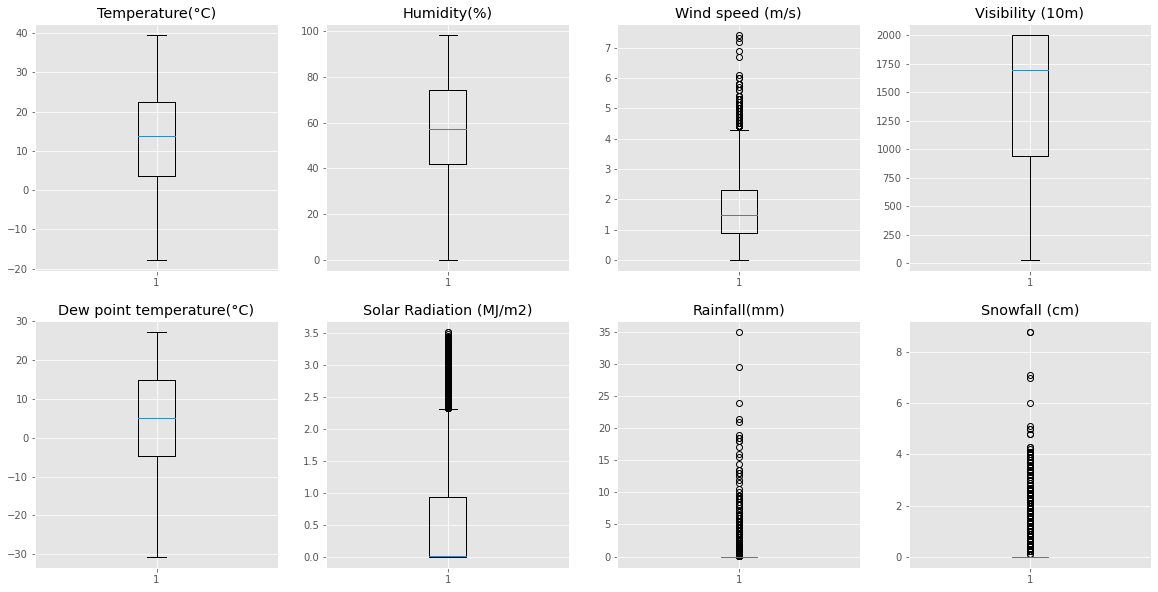

In [10]:
fig, ax = plt.subplots(2, 4, figsize=(20,10))
ax[0,0].boxplot(seoul_bike['Temperature(°C)'])
ax[0,0].set_title('Temperature(°C)')
ax[0,1].boxplot(seoul_bike['Humidity(%)'])
ax[0,1].set_title('Humidity(%)')
ax[0,2].boxplot(seoul_bike['Wind speed (m/s)'])
ax[0,2].set_title('Wind speed (m/s)')
ax[0,3].boxplot(seoul_bike['Visibility (10m)'])
ax[0,3].set_title('Visibility (10m)')
ax[1,0].boxplot(seoul_bike['Dew point temperature(°C)'])
ax[1,0].set_title('Dew point temperature(°C)')
ax[1,1].boxplot(seoul_bike['Solar Radiation (MJ/m2)'])
ax[1,1].set_title('Solar Radiation (MJ/m2)')
ax[1,2].boxplot(seoul_bike['Rainfall(mm)'])
ax[1,2].set_title('Rainfall(mm)')
ax[1,3].boxplot(seoul_bike['Snowfall (cm)'])
ax[1,3].set_title('Snowfall (cm)')
#fig.savefig(dir + "/images/indep_boxplot.png", bbox_inches = 'tight')

### Feature Extraction

In [11]:
seoul_bike['Year'] = seoul_bike['Date'].dt.year
seoul_bike['Month'] = seoul_bike['Date'].dt.month
seoul_bike['Day'] = seoul_bike['Date'].dt.day

Text(0.5, 1.0, 'Hour')

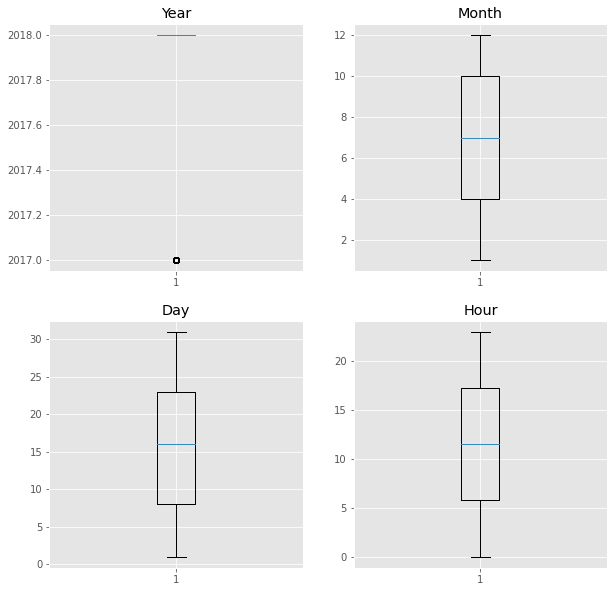

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
ax[0,0].boxplot(seoul_bike['Year'])
ax[0,0].set_title('Year')
ax[0,1].boxplot(seoul_bike['Month'])
ax[0,1].set_title('Month')
ax[1,0].boxplot(seoul_bike['Day'])
ax[1,0].set_title('Day')
ax[1,1].boxplot(seoul_bike['Hour'])
ax[1,1].set_title('Hour')

### Encoding Categorical Features

In [13]:
seoul_bike = pd.get_dummies(seoul_bike, columns=['Seasons', 'Holiday', 'Functioning Day'], drop_first=False)

### Standardization

In [14]:
# non-outlier features
scaler1 = StandardScaler()
X1 = seoul_bike[['Temperature(°C)','Humidity(%)','Visibility (10m)','Dew point temperature(°C)','Year','Month','Day','Hour']]
X1 = scaler1.fit_transform(X1)

In [15]:
# outlier features
scaler2 = RobustScaler()
X2 = seoul_bike[['Wind speed (m/s)','Solar Radiation (MJ/m2)','Rainfall(mm)','Snowfall (cm)']]
X2 = scaler2.fit_transform(X2)

## Data Splitting

In [16]:
X3 = np.concatenate((X1,X2),axis=1) 
X4 = pd.DataFrame(X3, columns =['Temperature(°C)','Humidity(%)','Visibility (10m)','Dew point temperature(°C)','Year','Month','Day','Hour', 'Wind speed (m/s)','Solar Radiation (MJ/m2)','Rainfall(mm)','Snowfall (cm)'])
X = pd.merge(X4, seoul_bike[['Seasons_Autumn','Seasons_Spring','Seasons_Summer','Seasons_Winter','Holiday_Holiday','Holiday_No Holiday','Functioning Day_No','Functioning Day_Yes']], left_index=True, right_index=True)
y = seoul_bike[['Rented Bike Count']]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=333)
base_train_prediction = {}
base_train_prediction['target'] = y_train.to_numpy().ravel()
base_test_prediction = {}
base_test_prediction['target'] = y_test.to_numpy().ravel()

In [18]:
base_cv_performance = {}
base_test_performance = {}
meta_cv_performance = {}
meta_test_performance = {}

## Base-level Learning

In [19]:
for m in base_models:
    model = base_models[m]
    base_test_performance[model.__class__.__name__] = {}
    
    prediction, performance = base_cv_learning(model, X_train, y_train, 5)
    base_train_prediction[model.__class__.__name__] = prediction
    base_cv_performance[model.__class__.__name__] = performance
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    try:
        base_test_prediction[model.__class__.__name__] = [items[0] for items in y_pred.tolist()]
    except:
        base_test_prediction[model.__class__.__name__] = y_pred.tolist()
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    base_test_performance[model.__class__.__name__]['RMSE'] = round(rmse, 3)
    base_test_performance[model.__class__.__name__]['MAE'] = round(mae, 3)
    base_test_performance[model.__class__.__name__]['R2'] = round(r2, 3)

In [20]:
base_cv_performance

{'LinearRegression': {'RMSE': 431.884, 'MAE': 322.458, 'R2': 0.55},
 'Ridge': {'RMSE': 431.879, 'MAE': 322.428, 'R2': 0.55},
 'Lasso': {'RMSE': 431.885, 'MAE': 322.145, 'R2': 0.55},
 'KernelRidge': {'RMSE': 318.111, 'MAE': 216.826, 'R2': 0.756},
 'KNeighborsRegressor': {'RMSE': 308.562, 'MAE': 196.401, 'R2': 0.77},
 'MLPRegressor': {'RMSE': 320.711, 'MAE': 221.43, 'R2': 0.752},
 'SVR': {'RMSE': 541.74, 'MAE': 370.645, 'R2': 0.293},
 'DecisionTreeRegressor': {'RMSE': 309.384, 'MAE': 180.057, 'R2': 0.769},
 'Earth': {'RMSE': 429.335, 'MAE': 321.446, 'R2': 0.556},
 'BaggingRegressor': {'RMSE': 237.254, 'MAE': 145.564, 'R2': 0.864},
 'RandomForestRegressor': {'RMSE': 224.956, 'MAE': 137.269, 'R2': 0.878},
 'GradientBoostingRegressor': {'RMSE': 252.327, 'MAE': 168.342, 'R2': 0.846},
 'XGBRegressor': {'RMSE': 220.127, 'MAE': 136.805, 'R2': 0.883},
 'LGBMRegressor': {'RMSE': 213.927, 'MAE': 133.812, 'R2': 0.889},
 'CatBoostRegressor': {'RMSE': 211.156, 'MAE': 132.758, 'R2': 0.892}}

In [21]:
base_test_performance

{'LinearRegression': {'RMSE': 437.853, 'MAE': 326.765, 'R2': 0.542},
 'Ridge': {'RMSE': 437.865, 'MAE': 326.748, 'R2': 0.542},
 'Lasso': {'RMSE': 438.698, 'MAE': 327.013, 'R2': 0.54},
 'KernelRidge': {'RMSE': 333.564, 'MAE': 227.02, 'R2': 0.734},
 'KNeighborsRegressor': {'RMSE': 306.489, 'MAE': 192.451, 'R2': 0.776},
 'MLPRegressor': {'RMSE': 331.762, 'MAE': 227.229, 'R2': 0.737},
 'SVR': {'RMSE': 535.479, 'MAE': 365.982, 'R2': 0.315},
 'DecisionTreeRegressor': {'RMSE': 322.222, 'MAE': 187.13, 'R2': 0.752},
 'Earth': {'RMSE': 436.442, 'MAE': 326.4, 'R2': 0.545},
 'BaggingRegressor': {'RMSE': 240.454, 'MAE': 146.279, 'R2': 0.862},
 'RandomForestRegressor': {'RMSE': 233.412, 'MAE': 140.617, 'R2': 0.87},
 'GradientBoostingRegressor': {'RMSE': 269.782, 'MAE': 181.927, 'R2': 0.826},
 'XGBRegressor': {'RMSE': 225.564, 'MAE': 138.074, 'R2': 0.878},
 'LGBMRegressor': {'RMSE': 218.842, 'MAE': 136.099, 'R2': 0.886},
 'CatBoostRegressor': {'RMSE': 213.575, 'MAE': 132.441, 'R2': 0.891}}

## Meta-level Learning

In [22]:
df_train_meta = pd.DataFrame(base_train_prediction)
y_train_meta = df_train_meta[['target']]
X_train_meta = df_train_meta.drop(columns=['target'], axis=1)

In [23]:
df_test_meta = pd.DataFrame(base_test_prediction)
y_test_meta = df_test_meta[['target']].to_numpy().ravel()
X_test_meta = df_test_meta.drop(columns=['target'], axis=1).to_numpy()

In [24]:
for m in meta_models:
    model = meta_models[m]
    meta_test_performance[model.__class__.__name__] = {}
    
    performance = meta_cv_learning(model, X_train_meta, y_train_meta, 5)
    meta_cv_performance[model.__class__.__name__] = performance
    
    model.fit(X_train_meta.to_numpy(), y_train_meta.to_numpy().ravel())
    y_pred = model.predict(X_test_meta)
    rmse = mean_squared_error(y_test_meta, y_pred, squared=False)
    mae = mean_absolute_error(y_test_meta, y_pred)
    r2 = r2_score(y_test, y_pred)
    meta_test_performance[model.__class__.__name__]['RMSE'] = round(rmse, 3)
    meta_test_performance[model.__class__.__name__]['MAE'] = round(mae, 3)
    meta_test_performance[model.__class__.__name__]['R2'] = round(r2, 3)

In [25]:
meta_cv_performance

{'LinearRegression': {'RMSE': 206.692, 'MAE': 126.182, 'R2': 0.897},
 'Ridge': {'RMSE': 206.692, 'MAE': 126.183, 'R2': 0.897},
 'LinearSearch': {'RMSE': 208.2, 'MAE': 128.664, 'R2': 0.895},
 'DifferentialEvolution': {'RMSE': 209.592, 'MAE': 128.718, 'R2': 0.894},
 'GeneticAlgorithm': {'RMSE': 206.811, 'MAE': 126.531, 'R2': 0.897},
 'ParticleSwarmOptimization': {'RMSE': 206.801, 'MAE': 126.497, 'R2': 0.897},
 'SimulatedAnnealing': {'RMSE': 221.756, 'MAE': 142.701, 'R2': 0.881},
 'GreedySearch': {'RMSE': 209.469, 'MAE': 128.725, 'R2': 0.894}}

In [26]:
meta_test_performance

{'LinearRegression': {'RMSE': 205.677, 'MAE': 123.679, 'R2': 0.899},
 'Ridge': {'RMSE': 205.677, 'MAE': 123.679, 'R2': 0.899},
 'LinearSearch': {'RMSE': 211.82, 'MAE': 130.105, 'R2': 0.893},
 'DifferentialEvolution': {'RMSE': 206.976, 'MAE': 125.077, 'R2': 0.898},
 'GeneticAlgorithm': {'RMSE': 205.194, 'MAE': 124.044, 'R2': 0.899},
 'ParticleSwarmOptimization': {'RMSE': 205.585, 'MAE': 123.712, 'R2': 0.899},
 'SimulatedAnnealing': {'RMSE': 248.555, 'MAE': 170.235, 'R2': 0.852},
 'GreedySearch': {'RMSE': 214.691, 'MAE': 130.413, 'R2': 0.89}}

## Save output

In [32]:
save_obj(base_cv_performance, 'data1_base_cv')
save_obj(base_test_performance, 'data1_base_test')
save_obj(meta_cv_performance, 'data1_meta_cv')
save_obj(meta_test_performance, 'data1_meta_test')

# Crimes & Communities Data

## Pre-processing

In [33]:
soup_link = BeautifulSoup(urlopen('http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.names'))
table_header = soup_link.find('p')

In [34]:
p = re.compile(r'@attribute\s+((?:\w+(?:|$)){1})')
columns = p.findall(table_header.text)

In [35]:
comm_crime = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data', sep=',', header=None, names=columns)

In [36]:
comm_crime = comm_crime.replace('?', np.nan)

total_missing = comm_crime.isnull().mean() * 100
drop_cols = total_missing[total_missing >= 0.5].index.to_list()
drop_cols.append('communityname')
comm_crime.drop(columns=drop_cols, inplace=True)

comm_crime['OtherPerCap'] = comm_crime['OtherPerCap'].astype(float).round(2)

comm_crime = comm_crime.fillna(comm_crime.mean())

In [37]:
comm_crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Columns: 103 entries, state to ViolentCrimesPerPop
dtypes: float64(101), int64(2)
memory usage: 1.6 MB


## Data Splitting

In [71]:
X = comm_crime.loc[:, comm_crime.columns != 'ViolentCrimesPerPop']
y = comm_crime[['ViolentCrimesPerPop']]

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=333)
base_train_prediction = {}
base_train_prediction['target'] = y_train.to_numpy().ravel()
base_test_prediction = {}
base_test_prediction['target'] = y_test.to_numpy().ravel()

In [73]:
base_cv_performance = {}
base_test_performance = {}
meta_cv_performance = {}
meta_test_performance = {}

## Base-level Learning

In [74]:
for m in base_models:
    model = base_models[m]
    base_test_performance[model.__class__.__name__] = {}
    
    prediction, performance = base_cv_learning(model, X_train, y_train, 5)
    base_train_prediction[model.__class__.__name__] = prediction
    base_cv_performance[model.__class__.__name__] = performance
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    try:
        base_test_prediction[model.__class__.__name__] = [items[0] for items in y_pred.tolist()]
    except:
        base_test_prediction[model.__class__.__name__] = y_pred.tolist()
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    base_test_performance[model.__class__.__name__]['RMSE'] = round(rmse, 3)
    base_test_performance[model.__class__.__name__]['MAE'] = round(mae, 3)
    base_test_performance[model.__class__.__name__]['R2'] = round(r2, 3)

In [75]:
base_cv_performance

{'LinearRegression': {'RMSE': 0.141, 'MAE': 0.1, 'R2': 0.634},
 'Ridge': {'RMSE': 0.139, 'MAE': 0.098, 'R2': 0.644},
 'Lasso': {'RMSE': 0.235, 'MAE': 0.179, 'R2': -0.012},
 'KernelRidge': {'RMSE': 0.148, 'MAE': 0.103, 'R2': 0.6},
 'KNeighborsRegressor': {'RMSE': 0.172, 'MAE': 0.118, 'R2': 0.455},
 'MLPRegressor': {'RMSE': 0.148, 'MAE': 0.105, 'R2': 0.599},
 'SVR': {'RMSE': 0.152, 'MAE': 0.106, 'R2': 0.576},
 'DecisionTreeRegressor': {'RMSE': 0.191, 'MAE': 0.128, 'R2': 0.321},
 'Earth': {'RMSE': 0.142, 'MAE': 0.098, 'R2': 0.631},
 'BaggingRegressor': {'RMSE': 0.146, 'MAE': 0.1, 'R2': 0.607},
 'RandomForestRegressor': {'RMSE': 0.141, 'MAE': 0.097, 'R2': 0.632},
 'GradientBoostingRegressor': {'RMSE': 0.138, 'MAE': 0.093, 'R2': 0.653},
 'XGBRegressor': {'RMSE': 0.145, 'MAE': 0.098, 'R2': 0.616},
 'LGBMRegressor': {'RMSE': 0.138, 'MAE': 0.092, 'R2': 0.651},
 'CatBoostRegressor': {'RMSE': 0.134, 'MAE': 0.09, 'R2': 0.67}}

In [76]:
base_test_performance

{'LinearRegression': {'RMSE': 0.13, 'MAE': 0.096, 'R2': 0.672},
 'Ridge': {'RMSE': 0.129, 'MAE': 0.093, 'R2': 0.677},
 'Lasso': {'RMSE': 0.226, 'MAE': 0.179, 'R2': -0.0},
 'KernelRidge': {'RMSE': 0.135, 'MAE': 0.098, 'R2': 0.646},
 'KNeighborsRegressor': {'RMSE': 0.168, 'MAE': 0.118, 'R2': 0.451},
 'MLPRegressor': {'RMSE': 0.14, 'MAE': 0.104, 'R2': 0.619},
 'SVR': {'RMSE': 0.14, 'MAE': 0.102, 'R2': 0.62},
 'DecisionTreeRegressor': {'RMSE': 0.201, 'MAE': 0.134, 'R2': 0.21},
 'Earth': {'RMSE': 0.13, 'MAE': 0.095, 'R2': 0.668},
 'BaggingRegressor': {'RMSE': 0.139, 'MAE': 0.096, 'R2': 0.622},
 'RandomForestRegressor': {'RMSE': 0.125, 'MAE': 0.09, 'R2': 0.694},
 'GradientBoostingRegressor': {'RMSE': 0.13, 'MAE': 0.091, 'R2': 0.67},
 'XGBRegressor': {'RMSE': 0.135, 'MAE': 0.095, 'R2': 0.643},
 'LGBMRegressor': {'RMSE': 0.13, 'MAE': 0.091, 'R2': 0.671},
 'CatBoostRegressor': {'RMSE': 0.125, 'MAE': 0.087, 'R2': 0.693}}

## Meta-level Learning

In [77]:
df_train_meta = pd.DataFrame(base_train_prediction)
y_train_meta = df_train_meta[['target']]
X_train_meta = df_train_meta.drop(columns=['target'], axis=1)

In [78]:
df_test_meta = pd.DataFrame(base_test_prediction)
y_test_meta = df_test_meta[['target']].to_numpy().ravel()
X_test_meta = df_test_meta.drop(columns=['target'], axis=1).to_numpy()

In [79]:
for m in meta_models:
    model = meta_models[m]
    meta_test_performance[model.__class__.__name__] = {}
    
    performance = meta_cv_learning(model, X_train_meta, y_train_meta, 5)
    meta_cv_performance[model.__class__.__name__] = performance
    
    model.fit(X_train_meta.to_numpy(), y_train_meta.to_numpy().ravel())
    y_pred = model.predict(X_test_meta)
    rmse = mean_squared_error(y_test_meta, y_pred, squared=False)
    mae = mean_absolute_error(y_test_meta, y_pred)
    r2 = r2_score(y_test, y_pred)
    meta_test_performance[model.__class__.__name__]['RMSE'] = round(rmse, 3)
    meta_test_performance[model.__class__.__name__]['MAE'] = round(mae, 3)
    meta_test_performance[model.__class__.__name__]['R2'] = round(r2, 3)

In [80]:
meta_cv_performance

{'LinearRegression': {'RMSE': 0.135, 'MAE': 0.09, 'R2': 0.666},
 'Ridge': {'RMSE': 0.134, 'MAE': 0.09, 'R2': 0.672},
 'LinearSearch': {'RMSE': 0.133, 'MAE': 0.091, 'R2': 0.673},
 'DifferentialEvolution': {'RMSE': 0.134, 'MAE': 0.09, 'R2': 0.671},
 'GeneticAlgorithm': {'RMSE': 0.134, 'MAE': 0.09, 'R2': 0.671},
 'ParticleSwarmOptimization': {'RMSE': 0.134, 'MAE': 0.091, 'R2': 0.669},
 'SimulatedAnnealing': {'RMSE': 0.135, 'MAE': 0.092, 'R2': 0.667},
 'GreedySearch': {'RMSE': 0.14, 'MAE': 0.096, 'R2': 0.641}}

In [81]:
meta_test_performance

{'LinearRegression': {'RMSE': 0.125, 'MAE': 0.087, 'R2': 0.696},
 'Ridge': {'RMSE': 0.124, 'MAE': 0.087, 'R2': 0.7},
 'LinearSearch': {'RMSE': 0.124, 'MAE': 0.088, 'R2': 0.699},
 'DifferentialEvolution': {'RMSE': 0.124, 'MAE': 0.087, 'R2': 0.698},
 'GeneticAlgorithm': {'RMSE': 0.125, 'MAE': 0.087, 'R2': 0.696},
 'ParticleSwarmOptimization': {'RMSE': 0.125, 'MAE': 0.087, 'R2': 0.695},
 'SimulatedAnnealing': {'RMSE': 0.124, 'MAE': 0.089, 'R2': 0.701},
 'GreedySearch': {'RMSE': 0.124, 'MAE': 0.088, 'R2': 0.699}}

## Save output

In [82]:
save_obj(base_cv_performance, 'data2_base_cv')
save_obj(base_test_performance, 'data2_base_test')
save_obj(meta_cv_performance, 'data2_meta_cv')
save_obj(meta_test_performance, 'data2_meta_test')

# Slump Test Data

## Pre-processing

In [84]:
slump = pd.read_csv(path + "/data/slump_test.data", header=0, encoding= 'unicode_escape')

In [85]:
slump.rename(columns={'Fly ash': 'FlyAsh', 'Coarse Aggr.': 'CoarseAggr', 'Fine Aggr.': 'FineAggr', 'SLUMP(cm)': 'Slump' , 'FLOW(cm)' : 'Flow' , 'Compressive Strength (28-day)(Mpa)': 'CompressiveStr'}, inplace=True)

In [86]:
slump.drop(columns=['No'], inplace=True)

In [87]:
#slump.drop(slump.tail(1).index,inplace=True)

In [88]:
slump.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Cement          103 non-null    float64
 1   Slag            103 non-null    float64
 2   FlyAsh          103 non-null    float64
 3   Water           103 non-null    float64
 4   SP              103 non-null    float64
 5   CoarseAggr      103 non-null    float64
 6   FineAggr        103 non-null    float64
 7   Slump           103 non-null    float64
 8   Flow            103 non-null    float64
 9   CompressiveStr  103 non-null    float64
dtypes: float64(10)
memory usage: 8.2 KB


In [89]:
slump.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Cement,103.0,229.894175,78.877230,137.00,152.00,248.00,303.900,374.00
Slag,103.0,77.973786,60.461363,0.00,0.05,100.00,125.000,193.00
FlyAsh,103.0,149.014563,85.418080,0.00,115.50,164.00,235.950,260.00
Water,103.0,197.167961,20.208158,160.00,180.00,196.00,209.500,240.00
SP,103.0,8.539806,2.807530,4.40,6.00,8.00,10.000,19.00
CoarseAggr,103.0,883.978641,88.391393,708.00,819.50,879.00,952.800,1049.90
FineAggr,103.0,739.604854,63.342117,640.60,684.50,742.70,788.000,902.00
Slump,103.0,18.048544,8.750844,0.00,14.50,21.50,24.000,29.00
Flow,103.0,49.610680,17.568610,20.00,38.50,54.00,63.750,78.00
CompressiveStr,103.0,36.039417,7.838232,17.19,30.90,35.52,41.205,58.53


In [90]:
X = slump[['Cement','Slag','FlyAsh','Water','SP','CoarseAggr','FineAggr']]
y = slump[['Slump']]
#y = slump[['Slump','Flow','CompressiveStr']]

## Data Splitting

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=333)
base_train_prediction = {}
base_train_prediction['target'] = y_train.to_numpy().ravel()
base_test_prediction = {}
base_test_prediction['target'] = y_test.to_numpy().ravel()

In [92]:
base_cv_performance = {}
base_test_performance = {}
meta_cv_performance = {}
meta_test_performance = {}

## Base-level Learning

In [93]:
for m in base_models:
    model = base_models[m]
    base_test_performance[model.__class__.__name__] = {}
    
    prediction, performance = base_cv_learning(model, X_train, y_train, 5)
    base_train_prediction[model.__class__.__name__] = prediction
    base_cv_performance[model.__class__.__name__] = performance
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    try:
        base_test_prediction[model.__class__.__name__] = [items[0] for items in y_pred.tolist()]
    except:
        base_test_prediction[model.__class__.__name__] = y_pred.tolist()
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    base_test_performance[model.__class__.__name__]['RMSE'] = round(rmse, 3)
    base_test_performance[model.__class__.__name__]['MAE'] = round(mae, 3)
    base_test_performance[model.__class__.__name__]['R2'] = round(r2, 3)

In [94]:
base_cv_performance

{'LinearRegression': {'RMSE': 7.934, 'MAE': 6.498, 'R2': -0.571},
 'Ridge': {'RMSE': 7.934, 'MAE': 6.497, 'R2': -0.57},
 'Lasso': {'RMSE': 7.804, 'MAE': 6.401, 'R2': -0.523},
 'KernelRidge': {'RMSE': 20.051, 'MAE': 18.283, 'R2': -16.7},
 'KNeighborsRegressor': {'RMSE': 8.001, 'MAE': 6.033, 'R2': -0.255},
 'MLPRegressor': {'RMSE': 17.796, 'MAE': 15.427, 'R2': -7.043},
 'SVR': {'RMSE': 8.723, 'MAE': 6.494, 'R2': -0.381},
 'DecisionTreeRegressor': {'RMSE': 9.655, 'MAE': 6.501, 'R2': -1.847},
 'Earth': {'RMSE': 7.854, 'MAE': 6.325, 'R2': -0.447},
 'BaggingRegressor': {'RMSE': 7.611, 'MAE': 5.611, 'R2': -0.288},
 'RandomForestRegressor': {'RMSE': 7.179, 'MAE': 5.172, 'R2': -0.22},
 'GradientBoostingRegressor': {'RMSE': 8.404, 'MAE': 5.98, 'R2': -0.981},
 'XGBRegressor': {'RMSE': 7.853, 'MAE': 5.612, 'R2': -0.621},
 'LGBMRegressor': {'RMSE': 7.534, 'MAE': 5.947, 'R2': -0.194},
 'CatBoostRegressor': {'RMSE': 7.55, 'MAE': 5.446, 'R2': -0.341}}

In [95]:
base_test_performance

{'LinearRegression': {'RMSE': 9.095, 'MAE': 7.076, 'R2': -0.021},
 'Ridge': {'RMSE': 9.094, 'MAE': 7.076, 'R2': -0.021},
 'Lasso': {'RMSE': 8.987, 'MAE': 7.067, 'R2': 0.003},
 'KernelRidge': {'RMSE': 19.151, 'MAE': 16.904, 'R2': -3.526},
 'KNeighborsRegressor': {'RMSE': 11.173, 'MAE': 8.326, 'R2': -0.54},
 'MLPRegressor': {'RMSE': 9.323, 'MAE': 6.278, 'R2': -0.072},
 'SVR': {'RMSE': 10.264, 'MAE': 6.858, 'R2': -0.3},
 'DecisionTreeRegressor': {'RMSE': 11.698, 'MAE': 8.298, 'R2': -0.689},
 'Earth': {'RMSE': 8.807, 'MAE': 7.166, 'R2': 0.043},
 'BaggingRegressor': {'RMSE': 9.336, 'MAE': 6.706, 'R2': -0.076},
 'RandomForestRegressor': {'RMSE': 8.328, 'MAE': 6.202, 'R2': 0.144},
 'GradientBoostingRegressor': {'RMSE': 9.826, 'MAE': 6.714, 'R2': -0.191},
 'XGBRegressor': {'RMSE': 9.805, 'MAE': 7.186, 'R2': -0.186},
 'LGBMRegressor': {'RMSE': 8.981, 'MAE': 6.878, 'R2': 0.005},
 'CatBoostRegressor': {'RMSE': 9.116, 'MAE': 6.394, 'R2': -0.025}}

## Meta-level Learning

In [96]:
df_train_meta = pd.DataFrame(base_train_prediction)
y_train_meta = df_train_meta[['target']]
X_train_meta = df_train_meta.drop(columns=['target'], axis=1)

In [97]:
df_test_meta = pd.DataFrame(base_test_prediction)
y_test_meta = df_test_meta[['target']].to_numpy().ravel()
X_test_meta = df_test_meta.drop(columns=['target'], axis=1).to_numpy()

In [98]:
for m in meta_models:
    model = meta_models[m]
    meta_test_performance[model.__class__.__name__] = {}
    
    performance = meta_cv_learning(model, X_train_meta, y_train_meta, 5)
    meta_cv_performance[model.__class__.__name__] = performance
    
    model.fit(X_train_meta.to_numpy(), y_train_meta.to_numpy().ravel())
    y_pred = model.predict(X_test_meta)
    rmse = mean_squared_error(y_test_meta, y_pred, squared=False)
    mae = mean_absolute_error(y_test_meta, y_pred)
    r2 = r2_score(y_test, y_pred)
    meta_test_performance[model.__class__.__name__]['RMSE'] = round(rmse, 3)
    meta_test_performance[model.__class__.__name__]['MAE'] = round(mae, 3)
    meta_test_performance[model.__class__.__name__]['R2'] = round(r2, 3)

In [99]:
meta_cv_performance

{'LinearRegression': {'RMSE': 9.805, 'MAE': 7.378, 'R2': -1.226},
 'Ridge': {'RMSE': 9.462, 'MAE': 7.215, 'R2': -1.005},
 'LinearSearch': {'RMSE': 8.193, 'MAE': 6.233, 'R2': -0.692},
 'DifferentialEvolution': {'RMSE': 9.221, 'MAE': 6.995, 'R2': -1.438},
 'GeneticAlgorithm': {'RMSE': 9.012, 'MAE': 6.702, 'R2': -1.225},
 'ParticleSwarmOptimization': {'RMSE': 9.188, 'MAE': 6.692, 'R2': -1.311},
 'SimulatedAnnealing': {'RMSE': 8.416, 'MAE': 6.309, 'R2': -0.85},
 'GreedySearch': {'RMSE': 15.436, 'MAE': 14.318, 'R2': -11.072}}

In [100]:
meta_test_performance

{'LinearRegression': {'RMSE': 8.22, 'MAE': 6.746, 'R2': 0.166},
 'Ridge': {'RMSE': 8.125, 'MAE': 6.579, 'R2': 0.185},
 'LinearSearch': {'RMSE': 8.632, 'MAE': 6.72, 'R2': 0.081},
 'DifferentialEvolution': {'RMSE': 8.66, 'MAE': 6.482, 'R2': 0.075},
 'GeneticAlgorithm': {'RMSE': 8.651, 'MAE': 6.542, 'R2': 0.077},
 'ParticleSwarmOptimization': {'RMSE': 8.738, 'MAE': 6.641, 'R2': 0.058},
 'SimulatedAnnealing': {'RMSE': 7.532, 'MAE': 6.131, 'R2': 0.3},
 'GreedySearch': {'RMSE': 14.921, 'MAE': 13.418, 'R2': -1.747}}

## Save output

In [101]:
save_obj(base_cv_performance, 'data3_base_cv')
save_obj(base_test_performance, 'data3_base_test')
save_obj(meta_cv_performance, 'data3_meta_cv')
save_obj(meta_test_performance, 'data3_meta_test')

# Sock Portfolio Data

## Pre-processing

In [103]:
stock = pd.read_csv(path + "/data/Stock Portofolio.csv", header=0, encoding= 'unicode_escape')

In [104]:
stock.rename(columns=dict(zip(stock.columns, ['largeBP', 'largeROE', 'largeSP', 'largeReturn', 'largeValue', 'smallRisk', 'Return'])), inplace=True)

In [105]:
stock.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
largeBP,63.0,0.166619,0.199304,0.0,0.0,0.167,0.2915,1.0
largeROE,63.0,0.166619,0.199304,0.0,0.0,0.167,0.2915,1.0
largeSP,63.0,0.166619,0.199304,0.0,0.0,0.167,0.2915,1.0
largeReturn,63.0,0.166619,0.199304,0.0,0.0,0.167,0.2915,1.0
largeValue,63.0,0.166619,0.199304,0.0,0.0,0.167,0.2915,1.0
smallRisk,63.0,0.166619,0.199304,0.0,0.0,0.167,0.2915,1.0
Return,63.0,14.923810,2.787224,7.0,13.8,15.300,17.0000,19.5


In [106]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   largeBP      63 non-null     float64
 1   largeROE     63 non-null     float64
 2   largeSP      63 non-null     float64
 3   largeReturn  63 non-null     float64
 4   largeValue   63 non-null     float64
 5   smallRisk    63 non-null     float64
 6   Return       63 non-null     float64
dtypes: float64(7)
memory usage: 3.6 KB


In [107]:
X = stock[['largeBP','largeROE','largeSP','largeReturn','largeValue','smallRisk']]
y = stock[['Return']]

## Data Splitting

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=333)
base_train_prediction = {}
base_train_prediction['target'] = y_train.to_numpy().ravel()
base_test_prediction = {}
base_test_prediction['target'] = y_test.to_numpy().ravel()

In [109]:
base_cv_performance = {}
base_test_performance = {}
meta_cv_performance = {}
meta_test_performance = {}

## Base-level Learning

In [110]:
for m in base_models:
    model = base_models[m]
    base_test_performance[model.__class__.__name__] = {}
    
    prediction, performance = base_cv_learning(model, X_train, y_train, 5)
    base_train_prediction[model.__class__.__name__] = prediction
    base_cv_performance[model.__class__.__name__] = performance
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    try:
        base_test_prediction[model.__class__.__name__] = [items[0] for items in y_pred.tolist()]
    except:
        base_test_prediction[model.__class__.__name__] = y_pred.tolist()
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    base_test_performance[model.__class__.__name__]['RMSE'] = round(rmse, 3)
    base_test_performance[model.__class__.__name__]['MAE'] = round(mae, 3)
    base_test_performance[model.__class__.__name__]['R2'] = round(r2, 3)

In [111]:
base_cv_performance

{'LinearRegression': {'RMSE': 2.282, 'MAE': 1.874, 'R2': 0.272},
 'Ridge': {'RMSE': 2.12, 'MAE': 1.782, 'R2': 0.381},
 'Lasso': {'RMSE': 2.728, 'MAE': 2.147, 'R2': -0.025},
 'KernelRidge': {'RMSE': 2.056, 'MAE': 1.694, 'R2': 0.424},
 'KNeighborsRegressor': {'RMSE': 1.959, 'MAE': 1.432, 'R2': 0.463},
 'MLPRegressor': {'RMSE': 1.9, 'MAE': 1.611, 'R2': 0.502},
 'SVR': {'RMSE': 1.888, 'MAE': 1.342, 'R2': 0.51},
 'DecisionTreeRegressor': {'RMSE': 1.642, 'MAE': 1.394, 'R2': 0.622},
 'Earth': {'RMSE': 1.428, 'MAE': 1.208, 'R2': 0.714},
 'BaggingRegressor': {'RMSE': 1.727, 'MAE': 1.4, 'R2': 0.583},
 'RandomForestRegressor': {'RMSE': 1.577, 'MAE': 1.291, 'R2': 0.654},
 'GradientBoostingRegressor': {'RMSE': 1.157, 'MAE': 0.958, 'R2': 0.806},
 'XGBRegressor': {'RMSE': 1.726, 'MAE': 1.347, 'R2': 0.593},
 'LGBMRegressor': {'RMSE': 2.699, 'MAE': 2.114, 'R2': -0.04},
 'CatBoostRegressor': {'RMSE': 1.545, 'MAE': 1.172, 'R2': 0.672}}

In [112]:
base_test_performance

{'LinearRegression': {'RMSE': 1.49, 'MAE': 1.267, 'R2': 0.719},
 'Ridge': {'RMSE': 1.842, 'MAE': 1.611, 'R2': 0.571},
 'Lasso': {'RMSE': 2.879, 'MAE': 2.307, 'R2': -0.049},
 'KernelRidge': {'RMSE': 2.119, 'MAE': 1.723, 'R2': 0.432},
 'KNeighborsRegressor': {'RMSE': 1.751, 'MAE': 1.489, 'R2': 0.612},
 'MLPRegressor': {'RMSE': 1.487, 'MAE': 1.299, 'R2': 0.72},
 'SVR': {'RMSE': 1.822, 'MAE': 1.382, 'R2': 0.58},
 'DecisionTreeRegressor': {'RMSE': 1.951, 'MAE': 1.546, 'R2': 0.519},
 'Earth': {'RMSE': 1.499, 'MAE': 1.157, 'R2': 0.716},
 'BaggingRegressor': {'RMSE': 1.881, 'MAE': 1.604, 'R2': 0.552},
 'RandomForestRegressor': {'RMSE': 1.614, 'MAE': 1.401, 'R2': 0.671},
 'GradientBoostingRegressor': {'RMSE': 1.155, 'MAE': 0.922, 'R2': 0.831},
 'XGBRegressor': {'RMSE': 1.232, 'MAE': 0.971, 'R2': 0.808},
 'LGBMRegressor': {'RMSE': 1.505, 'MAE': 1.121, 'R2': 0.714},
 'CatBoostRegressor': {'RMSE': 1.54, 'MAE': 1.25, 'R2': 0.7}}

## Meta-level Learning

In [113]:
df_train_meta = pd.DataFrame(base_train_prediction)
y_train_meta = df_train_meta[['target']]
X_train_meta = df_train_meta.drop(columns=['target'], axis=1)

In [114]:
df_test_meta = pd.DataFrame(base_test_prediction)
y_test_meta = df_test_meta[['target']].to_numpy().ravel()
X_test_meta = df_test_meta.drop(columns=['target'], axis=1).to_numpy()

In [115]:
for m in meta_models:
    model = meta_models[m]
    meta_test_performance[model.__class__.__name__] = {}
    
    performance = meta_cv_learning(model, X_train_meta, y_train_meta, 5)
    meta_cv_performance[model.__class__.__name__] = performance
    
    model.fit(X_train_meta.to_numpy(), y_train_meta.to_numpy().ravel())
    y_pred = model.predict(X_test_meta)
    rmse = mean_squared_error(y_test_meta, y_pred, squared=False)
    mae = mean_absolute_error(y_test_meta, y_pred)
    r2 = r2_score(y_test, y_pred)
    meta_test_performance[model.__class__.__name__]['RMSE'] = round(rmse, 3)
    meta_test_performance[model.__class__.__name__]['MAE'] = round(mae, 3)
    meta_test_performance[model.__class__.__name__]['R2'] = round(r2, 3)

In [116]:
meta_cv_performance

{'LinearRegression': {'RMSE': 1.521, 'MAE': 1.275, 'R2': 0.683},
 'Ridge': {'RMSE': 1.344, 'MAE': 1.147, 'R2': 0.753},
 'LinearSearch': {'RMSE': 1.214, 'MAE': 1.005, 'R2': 0.792},
 'DifferentialEvolution': {'RMSE': 1.207, 'MAE': 1.054, 'R2': 0.797},
 'GeneticAlgorithm': {'RMSE': 1.182, 'MAE': 0.994, 'R2': 0.806},
 'ParticleSwarmOptimization': {'RMSE': 1.373, 'MAE': 1.18, 'R2': 0.743},
 'SimulatedAnnealing': {'RMSE': 1.166, 'MAE': 0.992, 'R2': 0.809},
 'GreedySearch': {'RMSE': 1.979, 'MAE': 1.546, 'R2': 0.466}}

In [117]:
meta_test_performance

{'LinearRegression': {'RMSE': 1.408, 'MAE': 1.058, 'R2': 0.749},
 'Ridge': {'RMSE': 1.162, 'MAE': 0.905, 'R2': 0.829},
 'LinearSearch': {'RMSE': 1.418, 'MAE': 1.233, 'R2': 0.746},
 'DifferentialEvolution': {'RMSE': 1.008, 'MAE': 0.799, 'R2': 0.872},
 'GeneticAlgorithm': {'RMSE': 0.979, 'MAE': 0.797, 'R2': 0.879},
 'ParticleSwarmOptimization': {'RMSE': 1.159, 'MAE': 0.876, 'R2': 0.83},
 'SimulatedAnnealing': {'RMSE': 1.368, 'MAE': 1.084, 'R2': 0.763},
 'GreedySearch': {'RMSE': 1.952, 'MAE': 1.651, 'R2': 0.518}}

## Save output

In [118]:
save_obj(base_cv_performance, 'data4_base_cv')
save_obj(base_test_performance, 'data4_base_test')
save_obj(meta_cv_performance, 'data4_meta_cv')
save_obj(meta_test_performance, 'data4_meta_test')

# Analysis

In [137]:
for i in range(1,5):
    name = 'data{}'.format(i)
    
    # Base CV
    metrics00 = load_obj('{}_base_cv'.format(name))
    metrics00 = pd.DataFrame.from_dict(metrics00).transpose()
    metrics00.columns = [str(col) + '_CV' for col in metrics00.columns]
    metrics00.index.name = 'model'
    metrics00 = pd.concat({'base-level': metrics00}, names=['type'])
    
    # Base Test
    metrics01 = load_obj('{}_base_test'.format(name))
    metrics01 = pd.DataFrame.from_dict(metrics01).transpose()
    metrics01.columns = [str(col) + '_Test' for col in metrics01.columns]
    metrics01.index.name = 'model'
    metrics01 = pd.concat({'base-level': metrics01}, names=['type'])
    
    metrics0 = metrics00.join(metrics01)
    
    # Meta CV
    metrics10 = load_obj('{}_meta_cv'.format(name))
    metrics10 = pd.DataFrame.from_dict(metrics10).transpose()
    metrics10.columns = [str(col) + '_CV' for col in metrics10.columns]
    metrics10.index.name = 'model'
    metrics10 = pd.concat({'meta-level': metrics10}, names=['type'])
    
    # Meta Test
    metrics11 = load_obj('{}_meta_test'.format(name))
    metrics11 = pd.DataFrame.from_dict(metrics11).transpose()
    metrics11.columns = [str(col) + '_Test' for col in metrics11.columns]
    metrics11.index.name = 'model'
    metrics11 = pd.concat({'meta-level': metrics11}, names=['type'])
    
    metrics1 = metrics10.join(metrics11)
    
    final_metrics = pd.concat([metrics0, metrics1])
    final_metrics.to_pickle(path + '/output/metrics_'+ name + '.pkl')

In [138]:
metrics_data1 = pd.read_pickle(path + '/output/metrics_data1.pkl')
metrics_data2 = pd.read_pickle(path + '/output/metrics_data2.pkl')
metrics_data3 = pd.read_pickle(path + '/output/metrics_data3.pkl')
metrics_data4 = pd.read_pickle(path + '/output/metrics_data4.pkl')

In [139]:
# Bike Sharing
metrics_data1

RMSE_CV   MAE_CV  R2_CV  RMSE_Test  \
type       model                                                           
base-level LinearRegression           431.884  322.458  0.550    437.853   
           Ridge                      431.879  322.428  0.550    437.865   
           Lasso                      431.885  322.145  0.550    438.698   
           KernelRidge                318.111  216.826  0.756    333.564   
           KNeighborsRegressor        308.562  196.401  0.770    306.489   
           MLPRegressor               320.711  221.430  0.752    331.762   
           SVR                        541.740  370.645  0.293    535.479   
           DecisionTreeRegressor      309.384  180.057  0.769    322.222   
           Earth                      429.335  321.446  0.556    436.442   
           BaggingRegressor           237.254  145.564  0.864    240.454   
           RandomForestRegressor      224.956  137.269  0.878    233.412   
           GradientBoostingRegressor  252.327  168.342  0.846    269.782   
           XGBRegressor               220.127  136.805  0.883    225.564   
           LGBMRegressor              213.927  133.812  0.889    218.842   
           CatBoostRegressor          211.156  132.758  0.892    213.575   
meta-level LinearRegression           206.692  126.182  0.897    205.677   
           Ridge                      206.692  126.183  0.897    205.677   
           LinearSearch               208.200  128.664  0.895    211.820   
           DifferentialEvolution      209.592  128.718  0.894    206.976   
           GeneticAlgorithm           206.811  126.531  0.897    205.194   
           ParticleSwarmOptimization  206.801  126.497  0.897    205.585   
           SimulatedAnnealing         221.756  142.701  0.881    248.555   
           GreedySearch               209.469  128.725  0.894    214.691   

                                      MAE_Test  R2_Test  
type       model                                         
base-level LinearRegression            326.765    0.542  
           Ridge                       326.748    0.542  
           Lasso                       327.013    0.540  
           KernelRidge                 227.020    0.734  
           KNeighborsRegressor         192.451    0.776  
           MLPRegressor                227.229    0.737  
           SVR                         365.982    0.315  
           DecisionTreeRegressor       187.130    0.752  
           Earth                       326.400    0.545  
           BaggingRegressor            146.279    0.862  
           RandomForestRegressor       140.617    0.870  
           GradientBoostingRegressor   181.927    0.826  
           XGBRegressor                138.074    0.878  
           LGBMRegressor               136.099    0.886  
           CatBoostRegressor           132.441    0.891  
meta-level LinearRegression            123.679    0.899  
           Ridge                       123.679    0.899  
           LinearSearch                130.105    0.893  
           DifferentialEvolution       125.077    0.898  
           GeneticAlgorithm            124.044    0.899  
           ParticleSwarmOptimization   123.712    0.899  
           SimulatedAnnealing          170.235    0.852  
           GreedySearch                130.413    0.890

In [140]:
# Crimes
metrics_data2

RMSE_CV  MAE_CV  R2_CV  RMSE_Test  \
type       model                                                          
base-level LinearRegression             0.141   0.100  0.634      0.130   
           Ridge                        0.139   0.098  0.644      0.129   
           Lasso                        0.235   0.179 -0.012      0.226   
           KernelRidge                  0.148   0.103  0.600      0.135   
           KNeighborsRegressor          0.172   0.118  0.455      0.168   
           MLPRegressor                 0.148   0.105  0.599      0.140   
           SVR                          0.152   0.106  0.576      0.140   
           DecisionTreeRegressor        0.191   0.128  0.321      0.201   
           Earth                        0.142   0.098  0.631      0.130   
           BaggingRegressor             0.146   0.100  0.607      0.139   
           RandomForestRegressor        0.141   0.097  0.632      0.125   
           GradientBoostingRegressor    0.138   0.093  0.653      0.130   
           XGBRegressor                 0.145   0.098  0.616      0.135   
           LGBMRegressor                0.138   0.092  0.651      0.130   
           CatBoostRegressor            0.134   0.090  0.670      0.125   
meta-level LinearRegression             0.135   0.090  0.666      0.125   
           Ridge                        0.134   0.090  0.672      0.124   
           LinearSearch                 0.133   0.091  0.673      0.124   
           DifferentialEvolution        0.134   0.090  0.671      0.124   
           GeneticAlgorithm             0.134   0.090  0.671      0.125   
           ParticleSwarmOptimization    0.134   0.091  0.669      0.125   
           SimulatedAnnealing           0.135   0.092  0.667      0.124   
           GreedySearch                 0.140   0.096  0.641      0.124   

                                      MAE_Test  R2_Test  
type       model                                         
base-level LinearRegression              0.096    0.672  
           Ridge                         0.093    0.677  
           Lasso                         0.179   -0.000  
           KernelRidge                   0.098    0.646  
           KNeighborsRegressor           0.118    0.451  
           MLPRegressor                  0.104    0.619  
           SVR                           0.102    0.620  
           DecisionTreeRegressor         0.134    0.210  
           Earth                         0.095    0.668  
           BaggingRegressor              0.096    0.622  
           RandomForestRegressor         0.090    0.694  
           GradientBoostingRegressor     0.091    0.670  
           XGBRegressor                  0.095    0.643  
           LGBMRegressor                 0.091    0.671  
           CatBoostRegressor             0.087    0.693  
meta-level LinearRegression              0.087    0.696  
           Ridge                         0.087    0.700  
           LinearSearch                  0.088    0.699  
           DifferentialEvolution         0.087    0.698  
           GeneticAlgorithm              0.087    0.696  
           ParticleSwarmOptimization     0.087    0.695  
           SimulatedAnnealing            0.089    0.701  
           GreedySearch                  0.088    0.699

In [141]:
# Slump Test
metrics_data3

RMSE_CV  MAE_CV   R2_CV  RMSE_Test  \
type       model                                                           
base-level LinearRegression             7.934   6.498  -0.571      9.095   
           Ridge                        7.934   6.497  -0.570      9.094   
           Lasso                        7.804   6.401  -0.523      8.987   
           KernelRidge                 20.051  18.283 -16.700     19.151   
           KNeighborsRegressor          8.001   6.033  -0.255     11.173   
           MLPRegressor                17.796  15.427  -7.043      9.323   
           SVR                          8.723   6.494  -0.381     10.264   
           DecisionTreeRegressor        9.655   6.501  -1.847     11.698   
           Earth                        7.854   6.325  -0.447      8.807   
           BaggingRegressor             7.611   5.611  -0.288      9.336   
           RandomForestRegressor        7.179   5.172  -0.220      8.328   
           GradientBoostingRegressor    8.404   5.980  -0.981      9.826   
           XGBRegressor                 7.853   5.612  -0.621      9.805   
           LGBMRegressor                7.534   5.947  -0.194      8.981   
           CatBoostRegressor            7.550   5.446  -0.341      9.116   
meta-level LinearRegression             9.805   7.378  -1.226      8.220   
           Ridge                        9.462   7.215  -1.005      8.125   
           LinearSearch                 8.193   6.233  -0.692      8.632   
           DifferentialEvolution        9.221   6.995  -1.438      8.660   
           GeneticAlgorithm             9.012   6.702  -1.225      8.651   
           ParticleSwarmOptimization    9.188   6.692  -1.311      8.738   
           SimulatedAnnealing           8.416   6.309  -0.850      7.532   
           GreedySearch                15.436  14.318 -11.072     14.921   

                                      MAE_Test  R2_Test  
type       model                                         
base-level LinearRegression              7.076   -0.021  
           Ridge                         7.076   -0.021  
           Lasso                         7.067    0.003  
           KernelRidge                  16.904   -3.526  
           KNeighborsRegressor           8.326   -0.540  
           MLPRegressor                  6.278   -0.072  
           SVR                           6.858   -0.300  
           DecisionTreeRegressor         8.298   -0.689  
           Earth                         7.166    0.043  
           BaggingRegressor              6.706   -0.076  
           RandomForestRegressor         6.202    0.144  
           GradientBoostingRegressor     6.714   -0.191  
           XGBRegressor                  7.186   -0.186  
           LGBMRegressor                 6.878    0.005  
           CatBoostRegressor             6.394   -0.025  
meta-level LinearRegression              6.746    0.166  
           Ridge                         6.579    0.185  
           LinearSearch                  6.720    0.081  
           DifferentialEvolution         6.482    0.075  
           GeneticAlgorithm              6.542    0.077  
           ParticleSwarmOptimization     6.641    0.058  
           SimulatedAnnealing            6.131    0.300  
           GreedySearch                 13.418   -1.747

In [142]:
# Stock Portfolio
metrics_data4

RMSE_CV  MAE_CV  R2_CV  RMSE_Test  \
type       model                                                          
base-level LinearRegression             2.282   1.874  0.272      1.490   
           Ridge                        2.120   1.782  0.381      1.842   
           Lasso                        2.728   2.147 -0.025      2.879   
           KernelRidge                  2.056   1.694  0.424      2.119   
           KNeighborsRegressor          1.959   1.432  0.463      1.751   
           MLPRegressor                 1.900   1.611  0.502      1.487   
           SVR                          1.888   1.342  0.510      1.822   
           DecisionTreeRegressor        1.642   1.394  0.622      1.951   
           Earth                        1.428   1.208  0.714      1.499   
           BaggingRegressor             1.727   1.400  0.583      1.881   
           RandomForestRegressor        1.577   1.291  0.654      1.614   
           GradientBoostingRegressor    1.157   0.958  0.806      1.155   
           XGBRegressor                 1.726   1.347  0.593      1.232   
           LGBMRegressor                2.699   2.114 -0.040      1.505   
           CatBoostRegressor            1.545   1.172  0.672      1.540   
meta-level LinearRegression             1.521   1.275  0.683      1.408   
           Ridge                        1.344   1.147  0.753      1.162   
           LinearSearch                 1.214   1.005  0.792      1.418   
           DifferentialEvolution        1.207   1.054  0.797      1.008   
           GeneticAlgorithm             1.182   0.994  0.806      0.979   
           ParticleSwarmOptimization    1.373   1.180  0.743      1.159   
           SimulatedAnnealing           1.166   0.992  0.809      1.368   
           GreedySearch                 1.979   1.546  0.466      1.952   

                                      MAE_Test  R2_Test  
type       model                                         
base-level LinearRegression              1.267    0.719  
           Ridge                         1.611    0.571  
           Lasso                         2.307   -0.049  
           KernelRidge                   1.723    0.432  
           KNeighborsRegressor           1.489    0.612  
           MLPRegressor                  1.299    0.720  
           SVR                           1.382    0.580  
           DecisionTreeRegressor         1.546    0.519  
           Earth                         1.157    0.716  
           BaggingRegressor              1.604    0.552  
           RandomForestRegressor         1.401    0.671  
           GradientBoostingRegressor     0.922    0.831  
           XGBRegressor                  0.971    0.808  
           LGBMRegressor                 1.121    0.714  
           CatBoostRegressor             1.250    0.700  
meta-level LinearRegression              1.058    0.749  
           Ridge                         0.905    0.829  
           LinearSearch                  1.233    0.746  
           DifferentialEvolution         0.799    0.872  
           GeneticAlgorithm              0.797    0.879  
           ParticleSwarmOptimization     0.876    0.830  
           SimulatedAnnealing            1.084    0.763  
           GreedySearch                  1.651    0.518